In [105]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform
from numpy import random
from numpy import linspace, int32, float32, array, empty, zeros, int_, any

In [106]:
def get_naive_bins(state_pcoord, n_desired_we_bins):
    # The last two elements of this are the basis and target states respectively
    pcoord = state_pcoord
    pcoord_sort = np.argsort(pcoord).squeeze()
    cumsum = pcoord[pcoord_sort]

    n_active_bins = n_desired_we_bins - 1

    bin_bounds = np.linspace(0, cumsum[-1], n_active_bins + 1)[1:]
    bin_assignments = np.digitize(cumsum, bin_bounds, right=True)
    bin_states = bin_assignments[np.argsort(pcoord_sort)]

    return bin_states

def get_naive_bins_from_haMSM(state_pcoord, binbounds):
    return np.digitize(state_pcoord, binbounds, right=True)

def get_uniform_pi_v_bins(variance, discrepancy, steady_state, n_desired_we_bins):
    # The last two elements of this are the basis and target states respectively
    pi_v = steady_state * variance
    pi_v_sort = np.argsort(discrepancy).squeeze()
    cumsum = np.cumsum(pi_v[pi_v_sort])

    n_active_bins = n_desired_we_bins - 1

    bin_bounds = np.linspace(0, cumsum[-1], n_active_bins + 1)[1:]
    bin_assignments = np.digitize(cumsum, bin_bounds, right=True)
    bin_states = bin_assignments[np.argsort(pi_v_sort)]

    return bin_states

In [107]:
low_pair = np.load('haMSM_results/ntl9_low_friction_CA_featurization.pkl',allow_pickle=True)
low_CA   = np.load('haMSM_results/ntl9_low_friction_pair_featurization.pkl',allow_pickle=True)
high_3   = np.load('haMSM_results/ntl9_high_friction_3_clusters_per_bin.pkl',allow_pickle=True)
high_4   = np.load('haMSM_results/ntl9_high_friction_4_clusters_per_bin.pkl',allow_pickle=True)

binbounds = [0.0,1.00] + [1.10+0.1*i for i in range(35)] + [4.60+0.2*i for i in range(10)] + [6.60+0.6*i for i in range(6)] + [float('inf')]
n_bins = len(binbounds)

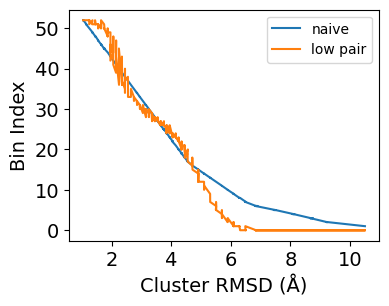

In [108]:
plt.figure(figsize=(4,3))
plt.plot(low_pair[0][1:],n_bins-get_naive_bins_from_haMSM(low_pair[0][1:], binbounds))
plt.plot(low_pair[0][1:],get_uniform_pi_v_bins(low_pair[3][1:], 
                                                  low_pair[2][1:], 
                                                  low_pair[1][1:], 
                                                  n_bins));
font = 14
plt.xticks(size=font);
plt.yticks(size=font);
plt.xlabel('Cluster RMSD (Å)',size=font);
plt.ylabel('Bin Index',size=font);

plt.legend(['naive','low pair'],fontsize=font-4);

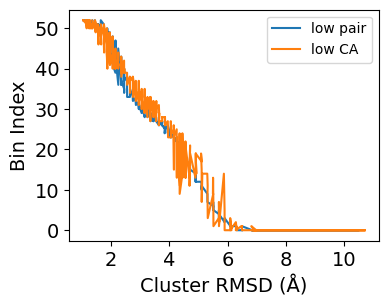

In [109]:
plt.figure(figsize=(4,3))
plt.plot(low_pair[0][1:],get_uniform_pi_v_bins(low_pair[3][1:], 
                                               low_pair[2][1:], 
                                               low_pair[1][1:], 
                                               n_bins))
plt.plot(low_CA[0][1:],get_uniform_pi_v_bins(low_CA[3][1:], 
                                             low_CA[2][1:], 
                                             low_CA[1][1:], 
                                             n_bins))

font = 14
plt.xticks(size=font);
plt.yticks(size=font);
plt.xlabel('Cluster RMSD (Å)',size=font);
plt.ylabel('Bin Index',size=font);

plt.legend(['low pair','low CA'],fontsize=font-4);

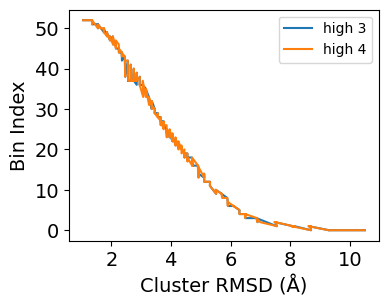

In [110]:
plt.figure(figsize=(4,3))
plt.plot(high_3[0][1:],get_uniform_pi_v_bins(high_3[3][1:], 
                                             high_3[2][1:], 
                                             high_3[1][1:], 
                                             n_bins))
plt.plot(high_4[0][1:],get_uniform_pi_v_bins(high_4[3][1:], 
                                             high_4[2][1:], 
                                             high_4[1][1:], 
                                             n_bins))

font = 14
plt.xticks(size=font);
plt.yticks(size=font);
plt.xlabel('Cluster RMSD (Å)',size=font);
plt.ylabel('Bin Index',size=font);

plt.legend(['high 3','high 4'],fontsize=font-4);

In [111]:
def var_const_within_bin(binning,allocation,h,v,pi):
# Following Eq 4 of the document  
    def get_pi_v_u(states_in_bin,v,pi,pi_u):
        value = 0 
        length = np.shape(states_in_bin)[1]
        for i in range(length):
            index = states_in_bin[0][i]
            value += pi[index]*v[index]/pi_u
        return value
    
    def get_Var_v(states_in_bin,v,pi,pi_u):
        value_first = 0 
        value_second = 0 
        length = np.shape(states_in_bin)[1]
        for i in range(length):
            index = states_in_bin[0][i]
            value_first += pi[index]*v[index]*v[index]/pi_u
            value_second += pi[index]*v[index]/pi_u        
        value = value_first - value_second**2   
        return value
    
    def get_Var_h(states_in_bin,h,pi,pi_u):
        value_first = 0 
        value_second = 0 
        length = np.shape(states_in_bin)[1]
        for i in range(length):
            index = states_in_bin[0][i]
            value_first += pi[index]*h[index]*h[index]/pi_u
            value_second += pi[index]*h[index]/pi_u
        value = value_first - value_second**2
        return value

    n_bins = len(allocation) - 1
    
    pi_v_u_const = np.zeros(n_bins)
    Var_v_const = np.zeros(n_bins)
    Var_h_const = np.zeros(n_bins)
    
    for i in range(n_bins):
    # Don't account for the last bin (product state)
        states_in_bin = np.where(binning==i)
        
        pi_u = sum(pi[states_in_bin])
        alpha_u = allocation[i]/sum(allocation)
        
        factor = pi_u * pi_u / alpha_u
        pi_v_u = get_pi_v_u(states_in_bin,v,pi,pi_u)
        Var_v = get_Var_v(states_in_bin,v,pi,pi_u)
        Var_h = get_Var_h(states_in_bin,h,pi,pi_u)
        
        pi_v_u_const[i] = factor * pi_v_u * pi_v_u
        Var_v_const[i] = factor * Var_v
        Var_h_const[i] = factor * Var_h
    
    return np.array([pi_v_u_const, Var_v_const, Var_h_const])

In [112]:
binning_low_pair_opt = get_uniform_pi_v_bins(low_pair[3][1:], low_pair[2][1:], low_pair[1][1:], n_bins)
binning_low_pair_naive = get_naive_bins(low_pair[0][1:], n_bins)

binning_low_CA_opt = get_uniform_pi_v_bins(low_CA[3][1:], low_CA[2][1:], low_CA[1][1:], n_bins)
binning_low_CA_naive = get_naive_bins(low_CA[0][1:], n_bins)

binning_high_3_opt = get_uniform_pi_v_bins(high_3[3][1:], high_3[2][1:], high_3[1][1:], n_bins)
binning_high_3_naive = get_naive_bins(high_3[0][1:], n_bins)

binning_high_4_opt = get_uniform_pi_v_bins(high_4[3][1:], high_4[2][1:], high_4[1][1:], n_bins)
binning_high_4_naive = get_naive_bins(high_4[0][1:], n_bins)

allocation = np.full(n_bins,4)

In [113]:
# The result is array of length n_bins with different (3 types of contributions) from each bin 
# Total variance constant is just the total sum of these arrays 
var_const_low_pair_opt   = var_const_within_bin(binning_low_pair_opt,
                                              allocation,
                                              low_pair[2][1:],low_pair[3][1:],low_pair[1][1:])
var_const_low_pair_naive = var_const_within_bin(binning_low_pair_naive,
                                              allocation,
                                              low_pair[2][1:],low_pair[3][1:],low_pair[1][1:])

var_const_low_CA_opt   = var_const_within_bin(binning_low_CA_opt,
                                              allocation,
                                              low_CA[2][1:],low_CA[3][1:],low_CA[1][1:])
var_const_low_CA_naive = var_const_within_bin(binning_low_CA_naive,
                                              allocation,
                                              low_CA[2][1:],low_CA[3][1:],low_CA[1][1:])

var_const_high_3_opt   = var_const_within_bin(binning_high_3_opt,
                                              allocation,
                                              high_3[2][1:],high_3[3][1:],high_3[1][1:])
var_const_high_3_naive = var_const_within_bin(binning_high_3_naive,
                                              allocation,
                                              high_3[2][1:],high_3[3][1:],high_3[1][1:])

var_const_high_4_opt   = var_const_within_bin(binning_high_4_opt,
                                              allocation,
                                              high_4[2][1:],high_4[3][1:],high_4[1][1:])
var_const_high_4_naive = var_const_within_bin(binning_high_4_naive,
                                              allocation,
                                              high_4[2][1:],high_4[3][1:],high_4[1][1:])

In [114]:
print(f'Low friction unoptimized variance constant (using haMSM functions estimated from CA featurization haMSM): \
{np.sum(var_const_low_CA_naive)}')
print(f'Low friction optimized (CA featurization) variance constant: {np.sum(var_const_low_CA_opt)}')

Low friction unoptimized variance constant (using haMSM functions estimated from CA featurization haMSM): 4.994998316680722e-07
Low friction optimized (CA featurization) variance constant: 1.7036694881342792e-07


In [115]:
print(f'Low friction unoptimized variance constant (using haMSM functions estimated from pair featurization haMSM): \
{np.sum(var_const_low_pair_naive)}')
print(f'Low friction optimized (pair featurization) variance constant: {np.sum(var_const_low_pair_opt)}')

Low friction unoptimized variance constant (using haMSM functions estimated from pair featurization haMSM): 2.4473350497914616e-07
Low friction optimized (pair featurization) variance constant: 9.219277518356148e-08


In [116]:
print(f'High friction unoptimized variance constant (using haMSM functions estimated from 3 clusters/bin haMSM): \
{np.sum(var_const_high_3_naive)}')
print(f'High friction optimized (3 clusters/bin) variance constant: {np.sum(var_const_high_3_opt)}')

High friction unoptimized variance constant (using haMSM functions estimated from 3 clusters/bin haMSM): 7.271888884294623e-17
High friction optimized (3 clusters/bin) variance constant: 2.81911440976456e-17


In [117]:
print(f'High friction unoptimized variance constant (using haMSM functions estimated from 4 clusters/bin haMSM): \
{np.sum(var_const_high_4_naive)}')
print(f'High friction optimized (4 clusters/bin) variance constant: {np.sum(var_const_high_4_opt)}')

High friction unoptimized variance constant (using haMSM functions estimated from 4 clusters/bin haMSM): 7.589602660664229e-17
High friction optimized (4 clusters/bin) variance constant: 2.6968652807265208e-17
